In [1]:
from sklearn.metrics import euclidean_distances
from sklearn.utils import check_X_y
import numpy as np
import random
import seaborn as sns; sns.set()
import pandas as pd

In [53]:
def discr_stat(
    X, Y, dissimilarity="euclidean", remove_isolates=True, return_rdfs=False
):
   
    check_X_y(X, Y, accept_sparse=True)

    uniques, counts = np.unique(Y, return_counts=True)
    if (counts != 1).sum() <= 1:
        msg = "You have passed a vector containing only a single unique sample id."
        raise ValueError(msg)
    if remove_isolates:
        idx = np.isin(Y, uniques[counts != 1])
        labels = Y[idx]
        
        if dissimilarity == "euclidean":
            X = X[idx]
        else:
            X = X[np.ix_(idx, idx)]
    else:
        labels = Y

    if dissimilarity == "euclidean":
        dissimilarities = euclidean_distances(X)
    else:
        dissimilarities = X

    rdfs = _discr_rdf(dissimilarities, labels)
    stat = np.nanmean(rdfs)

    if return_rdfs:
        return stat, rdfs
    else:
        return stat



In [23]:
def _discr_rdf(dissimilarities, labels):
    
    check_X_y(dissimilarities, labels, accept_sparse=True)

    rdfs = []
    for i, label in enumerate(labels):
        di = dissimilarities[i]

        # All other samples except its own label
        idx = labels == label
        Dij = di[~idx]

        # All samples except itself
        idx[i] = False
        Dii = di[idx]

        rdf = [1 - ((Dij < d).sum() + 0.5 * (Dij == d).sum()) / Dij.size for d in Dii]
        rdfs.append(rdf)

    out = np.full((len(rdfs), max(map(len, rdfs))), np.nan)
    for i, rdf in enumerate(rdfs):
        out[i, : len(rdf)] = rdf

    return out

In [59]:
def p_value(X,Y,bootstrap = 100):
    D0 = discr_stat(X,Y)
    
    print(D0)
    count = 1
    
    Y_ = Y.copy()
    for i in range(0,bootstrap):
        random.shuffle(Y_)
        D1 = discr_stat(X,Y_)
        if D1>D0:
            count +=1
            
    return count/(bootstrap+1), D0

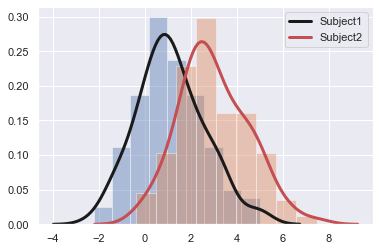

In [44]:
k = 16
t = 100
X = np.zeros((k,t),dtype=float)
Y = np.zeros(k,dtype=float)
cls = [8, 8]
sigma = [1.5, 1.5]
miu = [1, 3]

for i in range(0,k):
    if i < cls[0]:
        X[i,:] = np.random.normal(miu[0],sigma[0],t)
    else:
        X[i,:] = np.random.normal(miu[1],sigma[1],t)
        Y[i] = 1
        
sns.distplot(X[0,:], hist = True, kde_kws={"color": "k", "lw": 3, "label": "Subject1"})
sns.distplot(X[8,:], hist = True, kde_kws={"color": "r", "lw": 3, "label": "Subject2"})

#X = np.concatenate((sample1.reshape(1,-1),sample2.reshape(1,-1)),axis=0)
#Y = np.array([0,1])

In [ ]:
p = p_value(X,Y)

0.5018614478114478


In [51]:
p

9.999000099990002e-05

In [75]:
x = pd.read_csv('X_3.csv')
y = pd.read_csv('Y_3.csv')

X = np.zeros((300,2),dtype=float)
Y = np.zeros(300,dtype=float)

X[:,0] = x['V1']
X[:,1] = x['V2']
Y[:] = y['x']

In [76]:
p,D0 = p_value(X,Y)

0.5018614478114478


In [77]:
print(p)

0.18811881188118812
